# SQL Driven Machine Learning Tutorial: Customer Churn Prediction
In this tutorial, we will walk through an example of using SQL-driven machine learning to predict customer churn. We will be using the [JupySQL](https://github.com/ploomber/jupysql) package to run SQL queries within a Jupyter Notebook and a public dataset available on Kaggle.

Customer churn is a classification problem. In customer churn prediction, the goal is to classify customers into two categories: 
those who will churn (leave the company) and those who will not churn (remain with the company). 

This is a binary classification problem since there are only two possible outcomes (churn or not churn) for each customer.


## Table of Content:
1. Introduction of the problem, use case, and background story. 
2. Introduction to JupySQL and the dataset.
3. EDA + fitting the model 
4. Generating a stakeholder report
5. Questions and Answers

## Prerequisites
- Install and run a Jupyter Lab instance
- Install the JupySQL package using pip:

In [1]:
try:
    %pip install jupysql duckdb duckdb-engine seaborn scikit-learn xgboost --upgrade -q
    print("Installed successfully")
except Exception:
    print("Retry installing")

Note: you may need to restart the kernel to use updated packages.
Installed successfully


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn_evaluation.plot import Rank1D
from urllib.request import urlretrieve

We'll download the Telco Customer Churn dataset from Kaggle (I found a Github link) and save it as `churn.csv`.

## Initial setup
First, let's load the JupySQL extension and connect to an SQLite database in memory.

In [3]:
%load_ext sql
%sql duckdb://

### Import the dataset
Now we will import the dataset into a new table called customer_churn.

In [4]:
_ = urlretrieve(
    "https://raw.githubusercontent.com/treselle-systems/customer_churn_analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv",
    "churn.csv",
)

We can try querying the data and see it works, which means the engine is connected, my data is there locally.


In [5]:
%%sql
SELECT * FROM churn.csv LIMIT 3;

*  duckdb://
Done.


customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


Before diving into the machine learning process, let's explore the dataset to get a better understanding of the features and target variable.

Total number of rows in our dataset

In [6]:
%sql SELECT COUNT(*) AS num_rows FROM churn.csv;

*  duckdb://
Done.


num_rows
7043


Total number of columns in our dataset

Before diving into the machine learning process, let's explore the dataset to get a better understanding of the features and target variable.

In [7]:
_ = urlretrieve(
    "https://raw.githubusercontent.com/treselle-systems/customer_churn_analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv",
    "churn.csv",
)

We can try querying the data and see it works, which means the engine is connected, my data is there locally.

In [8]:
%%sql
SELECT * FROM churn.csv LIMIT 3;

*  duckdb://
Done.


customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


## Exploratory Data Analysis (EDA)
Before diving into data preprocessing and model training, let's perform some exploratory data analysis (EDA) to gain insights into the dataset and identify potential relationships between features and the target variable (customer churn).

Summary statistics
Let's start by calculating summary statistics for the numerical columns in the dataset.

## Dataset information
#### 1. Demographic Information

- `gender`: Whether the client is a female or a male (Female, Male).
- `SeniorCitizen`: Whether the client is a senior citizen or not ( 0, 1).
- `Partner`: Whether the client has a partner or not (Yes, No).
- `Dependents`: Whether the client has dependents or not (Yes, No).

#### 2. Customer Account Information

- `tenure`: Number of months the customer has stayed with the company (Multiple different numeric values).
- `Contract`: Indicates the customer’s current contract type (Month-to-Month, One year, Two year).
- `PaperlessBilling`: Whether the client has paperless billing or not (Yes, No).
- `PaymentMethod`: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit Card (automatic)).
- `MontlyCharges`: The amount charged to the customer monthly (Multiple different numeric values).
- `TotalCharges`: The total amount charged to the customer (Multiple different numeric values).

#### 3. Services Information

- `PhoneService`: Whether the client has a phone service or not (Yes, No).
- `MultipleLines`: Whether the client has multiple lines or not (No phone service, No, Yes).
- `InternetServices`: Whether the client is subscribed to Internet service with the company (DSL, Fiber optic, No)
- `OnlineSecurity`: Whether the client has online security or not (No internet service, No, Yes).
- `OnlineBackup`: Whether the client has online backup or not (No internet service, No, Yes).
- `DeviceProtection`: Whether the client has device protection or not (No internet service, No, Yes).
- `TechSupport`: Whether the client has tech support or not (No internet service, No, Yes).
- `StreamingTV`: Whether the client has streaming TV or not (No internet service, No, Yes).
- `StreamingMovies`: Whether the client has streaming movies or not (No internet service, No, Yes).

In [9]:
%%sql
SELECT
    AVG(tenure) AS avg_tenure,
    AVG(MonthlyCharges) AS avg_MonthlyCharges,
    AVG(TotalCharges) AS avg_TotalCharges
FROM
    churn.csv;

*  duckdb://
(duckdb.BinderException) Binder Error: No function matches the given name and argument types 'avg(VARCHAR)'. You might need to add explicit type casts.
	Candidate functions:
	avg(DECIMAL) -> DECIMAL
	avg(SMALLINT) -> DOUBLE
	avg(INTEGER) -> DOUBLE
	avg(BIGINT) -> DOUBLE
	avg(HUGEINT) -> DOUBLE
	avg(DOUBLE) -> DOUBLE

LINE 4:     AVG(TotalCharges) AS avg_TotalCharges
            ^
[SQL: SELECT
    AVG(tenure) AS avg_tenure,
    AVG(MonthlyCharges) AS avg_MonthlyCharges,
    AVG(TotalCharges) AS avg_TotalCharges
FROM
    churn.csv;]
(Background on this error at: https://sqlalche.me/e/20/f405)


### First problem!
It appears that the `TotalCharges` column is being treated as a `VARCHAR` instead of a `numeric data type`. To address this issue, let's cast the `TotalCharges` column to a numeric data type before querying and calculating the average.

First, let's find out if there are any non-numeric values in the TotalCharges column:

In [10]:
%%sql
SELECT
    TotalCharges
FROM
    churn.csv
WHERE
    NOT regexp_matches(TotalCharges, '^([0-9]+(\.[0-9]+)?)$')
LIMIT 10;

*  duckdb://
Done.


TotalCharges
""
""
""
""
""
""
""
""
""
""


If there are any non-numeric values, you can either remove those rows or replace them with appropriate values. For this example, let's replace them with `NULL`. In our case we'll just cast it directly and continue with our analysis.

You can cast directly the `TotalCharges` column to a numeric data type and calculate the averages. DuckDB has a built in feature for this called `TRY_CAST()`. The query from our previous cell (above, `cell 5`) should now return the average values for `tenure`, `MonthlyCharges`, and `TotalCharges`.

We'll perform the exact same query as before but with the `TRY_CAST()`:




In [11]:
%%sql
CREATE TABLE cleaned_churn AS
SELECT
    AVG(tenure) AS avg_tenure,
    AVG(MonthlyCharges) AS avg_MonthlyCharges,
    AVG(TRY_CAST(TotalCharges AS FLOAT)) AS avg_TotalCharges
FROM
    churn.csv;

*  duckdb://
Done.


Count
1


In [12]:
%sql select * from cleaned_churn limit 3

*  duckdb://
Done.


avg_tenure,avg_MonthlyCharges,avg_TotalCharges
32.37114865824223,64.76169246059922,2283.300441385536


### Churn distribution
Now let's check the distribution of churn in the dataset.

In [13]:
%%sql
SELECT
    Churn,
    COUNT(*) AS count,
    COUNT(*) * 1.0 / (SELECT COUNT(*) FROM churn.csv) AS percentage
FROM
    churn.csv
GROUP BY
    Churn;

*  duckdb://
Done.


Churn,count,percentage
No,5174,0.7346301292063041
Yes,1869,0.2653698707936959


### Saving our result directly into a dataframe
JupySQLn allows you to save your queried results into a pandas dataframe and move to python when necessary.
You can use `%sql`/`%%sql` with `<<` or the `=` sign:

In [14]:
%%sql data <<
SELECT
    *
FROM
    churn.csv

*  duckdb://
Done.


In [15]:
data = %sql SELECT * FROM churn.csv
data = data.DataFrame()

*  duckdb://
Done.


Now we can plot our data and see the total churn table we saw earlier in a visual form: 

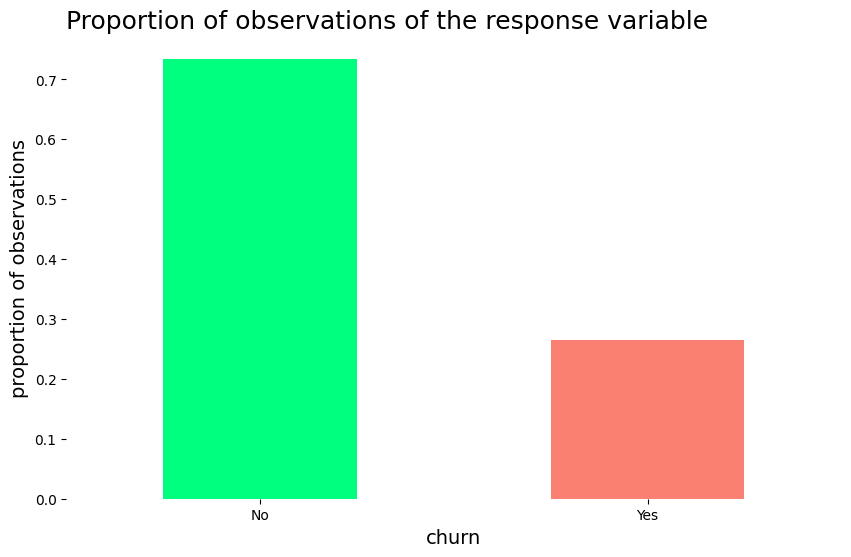

In [16]:
# Adding a plot for the specific data
# create a figure
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# proportion of observation of each class
prop_response = data["Churn"].value_counts(normalize=True)

# create a bar plot showing the percentage of churn
prop_response.plot(kind="bar", ax=ax, color=["springgreen", "salmon"])

# set title and labels
ax.set_title(
    "Proportion of observations of the response variable", fontsize=18, loc="left"
)
ax.set_xlabel("churn", fontsize=14)
ax.set_ylabel("proportion of observations", fontsize=14)
ax.tick_params(rotation="auto")

# eliminate the frame from the plot
spine_names = ("top", "right", "bottom", "left")
for spine_name in spine_names:
    ax.spines[spine_name].set_visible(False)

### Churn by contract type
Let's explore the relationship between contract type and churn.

In [17]:
%%sql
SELECT
    Contract,
    Churn,
    COUNT(*) AS count,
    COUNT(*) * 1.0 / (SELECT COUNT(*) FROM churn.csv WHERE Contract = c.Contract) AS percentage
FROM
    churn.csv AS c
GROUP BY
    Contract,
    Churn;

*  duckdb://
Done.


Contract,Churn,count,percentage
Month-to-month,No,2220,0.5729032258064516
One year,No,1307,0.8873048200950441
Month-to-month,Yes,1655,0.4270967741935484
Two year,No,1647,0.9716814159292035
Two year,Yes,48,0.02831858407079646
One year,Yes,166,0.11269517990495587


### Churn by payment method
We can also examine the relationship between payment methods and customer churn.

In [18]:
%%sql
SELECT
    PaymentMethod,
    Churn,
    COUNT(*) AS count,
    COUNT(*) * 1.0 / (SELECT COUNT(*) FROM churn.csv WHERE PaymentMethod = p.PaymentMethod) AS percentage
FROM
    churn.csv AS p
GROUP BY
    PaymentMethod,
    Churn
limit 3;

*  duckdb://
Done.


PaymentMethod,Churn,count,percentage
Electronic check,No,1294,0.5471458773784356
Mailed check,No,1304,0.8089330024813896
Mailed check,Yes,308,0.19106699751861042


### Correlation matrix
Finally, let's create a correlation matrix to explore relationships between the numerical features and customer churn.

In [19]:
%%sql df <<
SELECT tenure, MonthlyCharges, TRY_CAST(TotalCharges AS FLOAT) as TotalCharges, Churn FROM churn.csv;

*  duckdb://
Done.


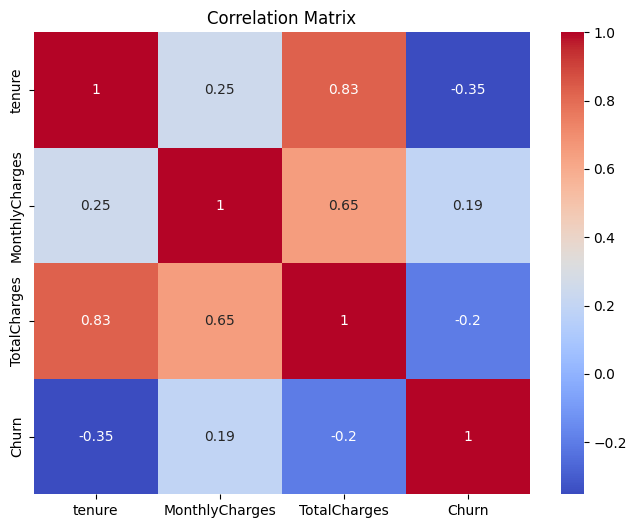

In [20]:
data_corr = df.DataFrame()
data_corr["Churn"] = data_corr["Churn"].apply(lambda x: 1 if x == "Yes" else 0)
correlation_matrix = data_corr.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

These EDA techniques provide valuable insights into the dataset and can help guide the feature engineering and model selection process. Based on the EDA results, you might consider focusing on specific features, transforming variables, or trying different machine learning algorithms to improve model performance.

Another cool thing we can do to simply get the imidiate insights pop out to us is use jupysql's built in functionality to view our data distribution:

In [21]:
%sqlcmd profile --table "churn.csv"

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
unique,7043,2,2,2,2,73,2,3,3,3,3,3,3,3,3,3,2,4,1585,6531,2
top,7590-VHVEG,Male,0,No,No,1,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,20.05,20.2,No
std,nan,nan,3.686e-01,nan,nan,2.456e+01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.009e+01,nan,nan
min,0002-ORFBO,Female,0,No,No,0,No,No,DSL,No,No,No,No,No,No,Month-to-month,No,Bank transfer (automatic),18.25,,No
mean,nan,nan,1.621e-01,nan,nan,3.237e+01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,6.476e+01,nan,nan
max,9995-HOTOH,Male,1,Yes,Yes,72,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Mailed check,118.75,999.9,Yes
freq,1,3555,5901,3641,4933,613,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,61,11,5174
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
75%,nan,nan,0.0,nan,nan,55.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,89.85,nan,nan
50%,nan,nan,0.0,nan,nan,29.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,70.35,nan,nan


We can also save it as an HTML report if we'd like to!

## Plotting directly from SQL

We can save queries and then use them in a similar manner to CTEs. We'll get the monthly charges and the total charges amount (cleaned), make sure we don't have bad values in them (nulls) and we'll use this query to plot the data.

In [22]:
%%sql --save clean_not_nulls --no-execute
SELECT *, TRY_CAST(TotalCharges AS FLOAT) as total_charges,
FROM churn.csv
WHERE MonthlyCharges IS NOT NULL 
AND total_charges IS NOT NULL

*  duckdb://
Skipping execution...


We can plot the two columns, but the monthly charges will be skewed since the values are not normalized, we can normalize or just plot the monthly charges seperately in the next cell.

<Axes: title={'center': "Boxplot from 'clean_not_nulls'"}>

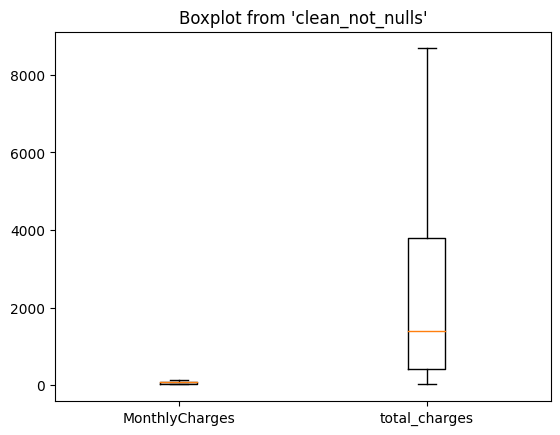

In [23]:
%sqlplot boxplot --column MonthlyCharges total_charges --table clean_not_nulls --with clean_not_nulls

<Axes: title={'center': "'MonthlyCharges' from 'clean_not_nulls'"}, ylabel='MonthlyCharges'>

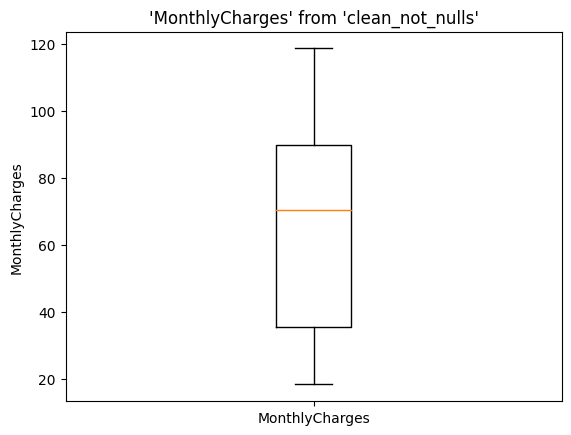

In [24]:
%sqlplot boxplot --column MonthlyCharges --table clean_not_nulls --with clean_not_nulls

Now we will look on the distribution of the data, this can help us detecting outliers that will eventually affect our model performance.

<Axes: title={'center': "'MonthlyCharges' from 'clean_not_nulls'"}, xlabel='MonthlyCharges', ylabel='Count'>

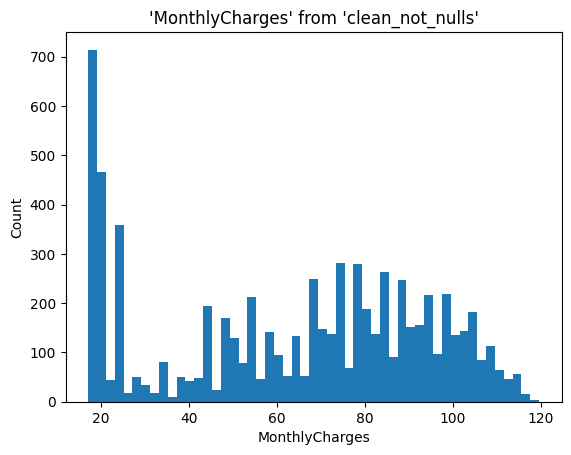

In [25]:
%sqlplot histogram --column MonthlyCharges --table clean_not_nulls --with clean_not_nulls

<Axes: title={'center': "'tenure' from 'clean_not_nulls'"}, xlabel='tenure', ylabel='Count'>

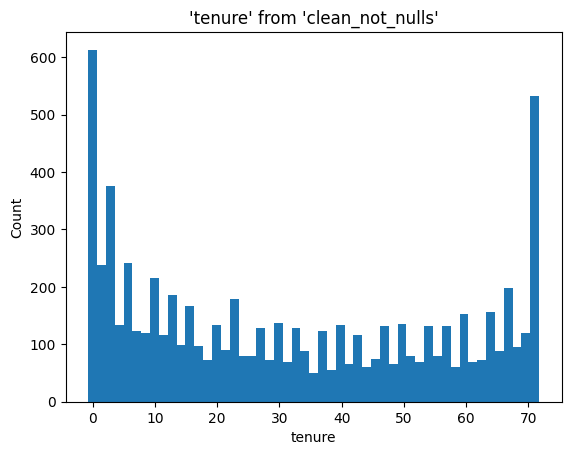

In [26]:
%sqlplot histogram --column tenure --table clean_not_nulls --with clean_not_nulls

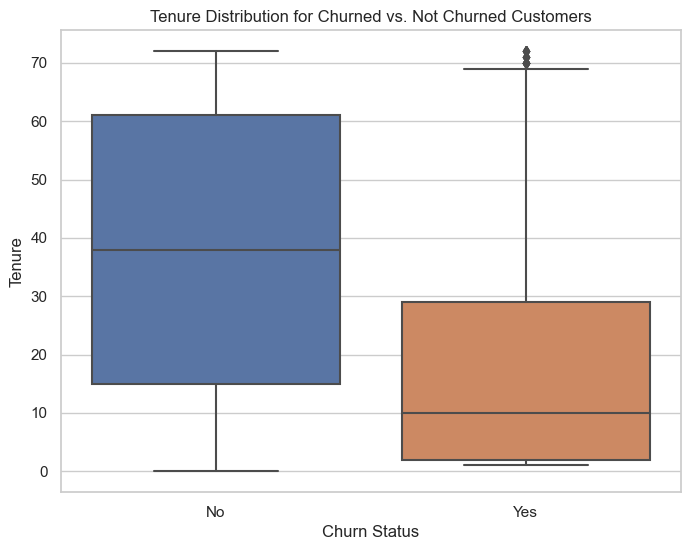

In [27]:
# Set the plot style
sns.set(style="whitegrid")

# Create a boxplot of tenure for churned and not churned customers
plt.figure(figsize=(8, 6))
sns.boxplot(x="Churn", y="tenure", data=data)
plt.xlabel("Churn Status")
plt.ylabel("Tenure")
plt.title("Tenure Distribution for Churned vs. Not Churned Customers")

# Display the plot
plt.show()

## Data preprocessing
To prepare the data for machine learning, we'll need to preprocess it. We will start by converting the categorical columns into numerical values using one-hot encoding. We'll also normalize the continuous features to bring them to the same scale. 

In the following example we're creating a mapping on certain values within the `Multiplelines` column.

In [28]:
%%sql
CREATE TABLE customer_churn_encoded AS
SELECT
    customerID,
    gender,
    SeniorCitizen,
    Partner,
    Dependents,
    tenure,
    PhoneService,
    MultipleLines,
    CASE
        WHEN InternetService = 'DSL' THEN 1
        ELSE 0
    END AS InternetService_DSL,
    CASE
        WHEN InternetService = 'Fiber optic' THEN 1
        ELSE 0
    END AS InternetService_Fiber_optic,
    CASE
        WHEN InternetService = 'No' THEN 1
        ELSE 0
    END AS InternetService_No,
    OnlineSecurity,
    OnlineBackup,
    DeviceProtection,
    TechSupport,
    StreamingTV,
    StreamingMovies,
    Contract,
    PaperlessBilling,
    PaymentMethod,
    MonthlyCharges,
    TotalCharges,
    Churn
FROM
    churn.csv;

*  duckdb://
Done.


Count
7043


SQL isn't always the answer, for instance, take this cell above for data preprocessing, it could be shorter with python and probably more efficient. The column encoding that happens above is a total of 2 lines in the cell bellow. So for simplicity from this point onward we'll continue with python. Afterall you need to use the right tool for the job.

In [29]:
# Consume our raw data (same one we just explored) show the columns
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In the following cell we're applying categorical labels to each of the columns, for instance in gender, instead of having values of male/female, we'll encode it to all females 1, all males 0 (or the opposite), mapping the values to numerical.

In [30]:
# Encode categorical columns
categorical_columns = [
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
    "Churn",
]
data_encoded = data[categorical_columns].apply(LabelEncoder().fit_transform)

## Data normalization
Now, we will normalize the continuous features (tenure, MonthlyCharges, and TotalCharges). We'll convert all of the column values to numeric values, normalize it, and remove null values.

In [31]:
# We'll need to clean the Totalcharges column again
# Convert TotalCharges to a numeric data type
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce")

# Handle any missing values in TotalCharges after conversion
data["TotalCharges"].fillna(data["TotalCharges"].mean(), inplace=True)

In [32]:
# Normalize numerical columns
numerical_columns = ["tenure", "MonthlyCharges", "TotalCharges"]

data_normalized = data[numerical_columns].apply(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Merge encoded and normalized DataFrames
data_preprocessed = pd.concat([data_encoded, data_normalized], axis=1)

## Train test split
To train and test our model, we will split the data into training (80%) and testing (20%) sets. This 20% testing data will later use us to evaluate our model.

In [33]:
# Splitting the data into training and testing sets
X = data_preprocessed.drop("Churn", axis=1)
y = data_preprocessed["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Training the model
We will now train a logistic regression model using the training data. 

The main goal is to understand if a customer will churn or not given its parameters.

In [34]:
model = LogisticRegression(solver="lbfgs", max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

## Testing the model
With the model trained, we can now test it by using our test dataset (which we splitted earlier) and calculate the overall accuracy.

Let's find out how accurate our model is by calculating as follows:

In [35]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

Accuracy:  0.815471965933286

Confusion Matrix:
 [[933 103]
 [157 216]]


This will return the accuracy of our logistic regression model in predicting customer churn. 
You can experiment with different models and feature selection techniques to improve the model's performance. 

81% isn't that good (although as we'll see soon it's probably the best performing model on that dataset without manipulating the data) and it does show us there's something in the data that affects performance. 
Usually we'll see it earlier in the EDA stage (for instance the missing values in our table report).

# Let's try improving our performance by using a different model
The model we're using together with the data we put in affects our final accuracy. We can try a different model together with some data cleaning techniques to improve our final result. Here I'll demonstrate how a simple model change can change our bottom line.

To improve the model's performance, we can try a combination of techniques such as hyperparameter tuning, feature selection, and ensemble methods. In this example, we'll use a Random Forest classifier with GridSearchCV for hyperparameter tuning and feature importance analysis for feature selection.



In [36]:
# Define the parameter grid for GridSearchCV
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2],
    "min_samples_leaf": [1, 5],
    "bootstrap": [True, False],
}

# Instantiate the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Fit the model
best_rf_model = RandomForestClassifier(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    bootstrap=best_params["bootstrap"],
    random_state=42,
)

best_rf_model.fit(X_train, y_train)
y_pred = best_rf_model.predict(X_test)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}


In [37]:
# Calculate the accuracy, classification report, and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

Accuracy: 0.808374733853797

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.88      1036
           1       0.68      0.52      0.59       373

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409


Confusion Matrix:
 [[946  90]
 [180 193]]


We can see that not only our performance didn't improve, they detiriorated. It's usually helpful to benchmark a few of the models and pick the best performing one. Usually, this has a lower impact on the overall performance compared to the quality of our data and the way we clean it before training.

## Feature Importance

Feature importance is a technique used in machine learning to determine the relative significance of input features in predicting the target variable. By identifying the most influential features, it helps in selecting the most relevant ones for model training, thus improving model performance and interpretability.

We'll use another open source package here: [Sklearn-evaluation](https://github.com/ploomber/sklearn-evaluation), this will allow us to compare model performance, and visualize it. 

In the example below we'll try to evaluate our feature importance and how it affects our model:

In [38]:
X.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

/Users/idomi/opt/miniconda3/envs/jext/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


<Axes: title={'center': 'Shapiro Ranking of 19 Features'}>

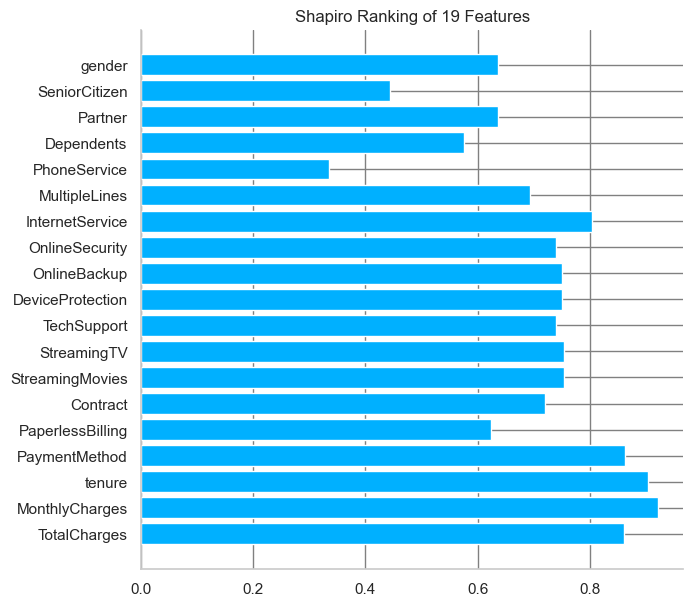

In [39]:
features = [
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
    "tenure",
    "MonthlyCharges",
    "TotalCharges",
]

actual = X[features]
rank1d = Rank1D(features=features)
rank1d.feature_ranks(actual)

**Feature selection**: By identifying the most relevant features, it allows for the reduction of 
input dimensions, leading to simpler and more efficient models. This can help reduce overfitting and improve generalization.

**Model interpretability**: Understanding the importance of different features in a model can
provide insights into the relationships between the features and the target variable. 
This makes the model more interpretable and can help in communicating the results to non-technical stakeholders.

**Better model performance**: By focusing on the most important features, models can achieve
better performance with less data and fewer parameters. This results in faster training times and potentially improved prediction accuracy.

The main advantage in our example above, we'll try to fit the model with less data, if we get to similar results, we are more efficient.

We'll drop 3 columns according to the graph above, as those are the least important features:
- `Dependents`
- `PhoneService`
- `SeniorCitizen`

In [40]:
# Splitting the data into training and testing sets
X = data_preprocessed.drop(
    columns=["Churn", "SeniorCitizen", "PhoneService", "Dependents"], axis=1
)
y = data_preprocessed["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LogisticRegression(solver="lbfgs", max_iter=2000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

Accuracy:  0.8105039034776437

Confusion Matrix:
 [[933 103]
 [164 209]]


We got a similar result (81% vs 81.5% accuracy) with 3 less columns, so essentially our model can be trained faster and save time, it all depends on what metric we're trying to optimize.

## ROC curve
Another way we can evaluate our model is the ROC curve.

An **ROC (Receiver Operating Characteristic) curve** is a graphical representation of a binary classifier's performance
across various classification thresholds. It plots the true positive rate (sensitivity) 
against the false positive rate (1-specificity), highlighting the trade-off between correctly 
identifying positive cases and incorrectly classifying negative cases.

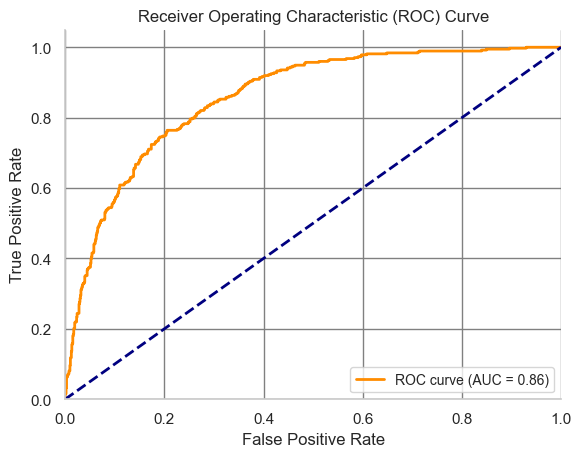

In [41]:
# Calculate the predicted probabilities for the test data
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate the FPR and TPR at various thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

## Conclusion
In this tutorial, we walked through a SQL-driven machine learning example using the [JupySQL](https://github.com/ploomber/jupysql) package to predict customer churn. 

We explored the dataset, preprocessed the data, split it into training and testing sets, trained a logistic regression model, tested it, and performed cross-validation to measure the model's performance.

You can continue to experiment with different machine learning algorithms and feature selection techniques to improve your model's performance. Additionally, you can integrate this SQL-driven approach into your data pipeline to automate and scale your machine learning projects.

Feel free to connect and stay in touch!

Ido - ido@ploomber.io

# Questions?